## Imports

In [1]:
%load_ext tensorboard
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import random
import h5py
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from datetime import datetime, timedelta 


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


# set manual seed for reproducibility
seed = 1001

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mon May 03 11:22:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.50       Driver Version: 442.50       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX250      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Re-Format Time

In [2]:
def get_time_format(seconds):
    sec = timedelta(seconds=int(seconds))
    d = datetime(1, 1, 1) + sec
    if d.day-1 == 1:
        return "%.2d:%.2d:%.2d:%.2d" % (d.day-1, d.hour, d.minute, d.second)
    return "%.2d:%.2d:%.2d" % (d.hour, d.minute, d.second)


def calculate_time(start_time):
    return get_time_format(time.time() - start_time)

## Visualize Data

In [3]:
def get_flow(file_name): # 将读取文件写成一个函数
   
    flow_data = np.load(file_name) # 载入交通流量数据
    print([key for key in flow_data.keys()]) # 打印看看key是什么  
    print(flow_data["data"].shape)  # (16992, 307, 3)，16992是时间(59*24*12)，307是节点数，3表示每一维特征的维度（类似于二维的列）
    flow_data = flow_data['data'] # [T, N, D]，T为时间，N为节点数，D为节点特征
    return flow_data

['data']
(16992, 307, 3)
(16992, 307, 3)


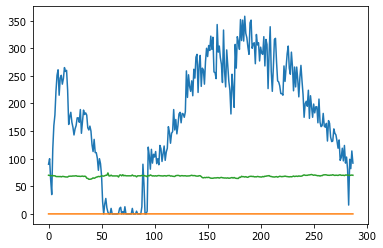

In [4]:
# traffic_data = get_flow("PeMS/PeMS08.npz")
# node_id = 10
# print(traffic_data.shape)
    
# plt.plot(traffic_data[:24*12, node_id, 0])  # 0维特征
# plt.savefig("asset/node_{:3d}_PEMS08_1.png".format(node_id))

# plt.plot(traffic_data[:24 * 12, node_id, 1])  # 1维特征
# plt.savefig("asset/node_{:3d}_PEMS08_2.png".format(node_id))

# plt.plot(traffic_data[:24 * 12, node_id, 2])  # 2维特征
# plt.savefig("asset/node_{:3d}_PEMS08_3.png".format(node_id))
    
traffic_data = get_flow("PeMS/PeMS04.npz")
node_id = 10
print(traffic_data.shape)
    
plt.plot(traffic_data[:24*12, node_id, 0])  # 0维特征
plt.savefig("asset/node_{:3d}_PEMS04_1.png".format(node_id))

plt.plot(traffic_data[:24 * 12, node_id, 1])  # 1维特征
plt.savefig("asset/node_{:3d}_PEMS04_2.png".format(node_id))

plt.plot(traffic_data[:24 * 12, node_id, 2])  # 2维特征
plt.savefig("asset/node_{:3d}_PEMS04_3.png".format(node_id))

## Load the PEMS Dataset

In [5]:
# =============================================================================
# 处理成邻接矩阵的程序如下：
# =============================================================================
def get_adjacent_matrix(distance_file: str, num_nodes: int, id_file: str = None, graph_type="connect") -> np.array:
    """
    :param distance_file: str, path of csv file to save the distances between nodes.
    :param num_nodes: int, number of nodes in the graph
    :param id_file: str, path of txt file to save the order of the nodes.就是排序节点的绝对编号所用到的，这里排好了，不需要
    :param graph_type: str, ["connect", "distance"]，这个就是考不考虑节点之间的距离
    :return:
        np.array(N, N)
    """
    A = np.zeros([int(num_nodes), int(num_nodes)])# 构造全0的邻接矩阵

    if id_file:  # 就是给节点排序的绝对文件，这里是None，则表示不需要
        with open(id_file, "r") as f_id: 
            # 将绝对编号用enumerate()函数打包成一个索引序列，然后用node_id这个绝对编号做key，用idx这个索引做value
            node_id_dict = {int(node_id): idx for idx, node_id in enumerate(f_id.read().strip().split("\n"))}

            with open(distance_file, "r") as f_d:
                f_d.readline() # 表头，跳过第一行.
                reader = csv.reader(f_d) # 读取.csv文件.
                for item in reader:   # 将一行给item组成列表
                    if len(item) != 3: # 长度应为3，不为3则数据有问题，跳过
                        continue
                    i, j, distance = int(item[0]), int(item[1]), float(item[2]) # 节点i，节点j，距离distance
                    if graph_type == "connect":  # 这个就是将两个节点的权重都设为1，也就相当于不要权重
                        A[node_id_dict[i], node_id_dict[j]] = 1.
                        A[node_id_dict[j], node_id_dict[i]] = 1.
                    elif graph_type == "distance":  # 这个是有权重，下面是权重计算方法
                        A[node_id_dict[i], node_id_dict[j]] = 1. / distance
                        A[node_id_dict[j], node_id_dict[i]] = 1. / distance
                    else:
                        raise ValueError("graph type is not correct (connect or distance)")
        return A

    with open(distance_file, "r") as f_d:
        f_d.readline()  # 表头，跳过第一行.
        reader = csv.reader(f_d)  # 读取.csv文件.
        for item in reader:  # 将一行给item组成列表
            if len(item) != 3: # 长度应为3，不为3则数据有问题，跳过
                continue
            i, j, distance = int(item[0]), int(item[1]), float(item[2])

            if graph_type == "connect":  # 这个就是将两个节点的权重都设为1，也就相当于不要权重
                A[i, j], A[j, i] = 1., 1.
            elif graph_type == "distance": # 这个是有权重，下面是权重计算方法
                A[i, j] = 1. / distance
                A[j, i] = 1. / distance
            else:
                raise ValueError("graph type is not correct (connect or distance)")

    return A

In [6]:
# =============================================================================
# （2）读入流量数据
# 流量数据就是每个节点的特征数据，这个函数在说数据分析的时候其实已经写的差不多了，这里再看看
# =============================================================================
def get_flow_data(flow_file: str) -> np.array:   # 这个是载入流量数据,返回numpy的多维数组
    """
    :param flow_file: str, path of .npz file to save the traffic flow data
    :return:
        np.array(N, T, D)
    """
    data = np.load(flow_file)

    flow_data = data['data'].transpose([1, 0, 2])[:, :, 0][:, :, np.newaxis]  # [N, T, D],transpose就是转置，让节点纬度在第0位，N为节点数，T为时间，D为节点特征
    # [:, :, 0]就是只取第一个特征，[:, :, np.newaxis]就是增加一个维度，因为：一般特征比一个多，即使是一个，保持这样的习惯，便于通用的处理问题

    return flow_data  # [N, T, D]

In [7]:

# =============================================================================
# （3）把前面读入的数据处理成模型所需要的train_data和test_data
# =============================================================================
class LoadData(Dataset):# 这个就是把读入的数据处理成模型需要的训练数据和测试数据，一个一个样本能读取出来
    def __init__(self, data_path, num_nodes, divide_days, time_interval, history_length, train_mode):
        """
        :param data_path: list, ["graph file name" , "flow data file name"], 保存数据文件名的路径。
        :param num_nodes: int, 节点的数量。
        :param divide_days: list, [ days of train data, days of test data], 分割原始数据的列表。
        :param time_interval: int, 两个交通数据记录之间的时间间隔（分钟）。
        :param history_length: int, 要使用的历史数据的长度。
        :param train_mode: list, ["train", "test"].
        """

        self.data_path = data_path
        self.num_nodes = num_nodes
        self.train_mode = train_mode
        self.train_days = divide_days[0]  # 45   59-14 = 45, train_data
        self.test_days = divide_days[1]  # 14  7*2 = 14 ,test_data
        self.history_length = history_length  # 6 30/5 = 6, 历史长度为6
        self.time_interval = time_interval  # 5 min

        self.one_day_length = int(24 * 60 / self.time_interval) # 一整天的数据量

        self.graph = get_adjacent_matrix(distance_file=data_path[0], num_nodes=num_nodes)

        self.flow_norm, self.flow_data = self.pre_process_data(data=get_flow_data(data_path[1]), norm_dim=1)# self.flow_norm为归一化的基

    def __len__(self): # 表示数据集的长度
        """
        :return: length of dataset (number of samples).
        """
        if self.train_mode == "train":
            return self.train_days * self.one_day_length - self.history_length   #　每个样本都能测试，测试样本数　＝　测试总长度
        elif self.train_mode == "test":
            return self.test_days * self.one_day_length  #　每个样本都能测试，测试样本数　＝　测试总长度
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

    def __getitem__(self, index):  # 功能是如何取每一个样本 (x, y), index = [0, L1 - 1]这个是根据数据集的长度确定的
        """
        :param index: int, range between [0, length - 1].
        :return:
            graph: torch.tensor, [N, N].
            data_x: torch.tensor, [N, H, D].
            data_y: torch.tensor, [N, 1, D].
        """
        if self.train_mode == "train":
            index = index  #　训练集的数据是从时间０开始的，这个是每一个流量数据，要和样本（ｘ,y）区别
        elif self.train_mode == "test":
            index += self.train_days * self.one_day_length #　有一个偏移量
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        data_x, data_y = LoadData.slice_data(self.flow_data, self.history_length, index, self.train_mode)

        data_x = LoadData.to_tensor(data_x)  # [N, H, D] # 转换成张量
        data_y = LoadData.to_tensor(data_y).unsqueeze(1)  # [N, 1, D] 　# 转换成张量，在时间维度上扩维

        return {"graph": LoadData.to_tensor(self.graph), "flow_x": data_x, "flow_y": data_y}  #组成词典返回

    @staticmethod
    def slice_data(data, history_length, index, train_mode):#　根据历史长度,下标来划分数据样本
        """
        :param data: np.array, normalized traffic data.
        :param history_length: int, length of history data to be used.
        :param index: int, index on temporal axis.
        :param train_mode: str, ["train", "test"].
        :return:
            data_x: np.array, [N, H, D].
            data_y: np.array [N, D].
        """
        if train_mode == "train":
            start_index = index #开始下标就是时间下标本身，这个是闭区间
            end_index = index + history_length #结束下标,这个是开区间
        elif train_mode == "test":
            start_index = index - history_length #　开始下标，这个最后面贴图了，可以帮助理解
            end_index = index # 结束下标
        else:
            raise ValueError("train model {} is not defined".format(train_mode))

        data_x = data[:, start_index: end_index] # 在切第二维，不包括end_index
        data_y = data[:, end_index]   # 把上面的end_index取上

        return data_x, data_y

    @staticmethod
    def pre_process_data(data, norm_dim):  # 预处理,归一化
        """
        :param data: np.array,原始的交通流量数据
        :param norm_dim: int, 归一化的维度，就是说在哪个维度上归一化,这里是在dim=1时间维度上
        :return:
            norm_base: list, [max_data, min_data], 这个是归一化的基.
            norm_data: np.array, normalized traffic data.
        """
        norm_base = LoadData.normalize_base(data, norm_dim)  #  计算 normalize basefind the normalize base
        norm_data = LoadData.normalize_data(norm_base[0], norm_base[1], data)  # # 归一化后的流量数据

        return norm_base, norm_data  #返回基是为了恢复数据做准备的

    @staticmethod
    def normalize_base(data, norm_dim): #计算归一化的基
        """
        :param data: np.array,原始的交通流量数据
        :param norm_dim: int, normalization dimension. 归一化的维度，就是说在哪个维度上归一化,这里是在dim=1时间维度上
        :return:
            max_data: np.array
            min_data: np.array
        """
        max_data = np.max(data, norm_dim, keepdims=True)  # [N, T, D] , norm_dim=1, [N, 1, D], keepdims=True就保持了纬度一致
        min_data = np.min(data, norm_dim, keepdims=True)
        return max_data, min_data  # 返回最大值和最小值

    @staticmethod
    def normalize_data(max_data, min_data, data): #计算归一化的流量数据，用的是最大值最小值归一化法
        """
        :param max_data: np.array, max data.
        :param min_data: np.array, min data.
        :param data: np.array, original traffic data without normalization.
        :return:
            np.array, normalized traffic data.
        """
        mid = min_data
        base = max_data - min_data
        normalized_data = (data - mid) / base

        return normalized_data

    @staticmethod
    def recover_data(max_data, min_data, data):  # 恢复数据时使用的，为可视化比较做准备的
        """
        :param max_data: np.array, max data.
        :param min_data: np.array, min data.
        :param data: np.array, normalized data.
        :return:
            recovered_data: np.array, recovered data.
        """
        mid = min_data
        base = max_data - min_data

        recovered_data = data * base + mid

        return recovered_data #这个就是原始的数据

    @staticmethod
    def to_tensor(data):
        return torch.tensor(data, dtype=torch.float)

In [8]:
# Loading Dataset
train_data = LoadData(data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=10)
test_data = LoadData(data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=10)
print(len(train_data)) #整个train_data 有12954长度 每条数据的维度是[307, 6, 1] 标签的长度是[307, 1, 1]
print(len(test_data))
print(train_data[0]["flow_x"].size())
print(train_data[0]["flow_y"].size())


12954
4032
torch.Size([307, 6, 1])
torch.Size([307, 1, 1])


## visualize result and Evaluation

In [44]:
class Evaluation(object):
    def __init__(self):
        pass

    @staticmethod
    def mae_(target, output):
        return np.mean(np.abs(target - output))

    @staticmethod
    def mape_(target, output):
        return np.mean(np.abs(target - output) / (target + 5)) # 加５是因为target有可能为0，当然只要不太大，加几都行

    @staticmethod
    def rmse_(target, output):
        return np.sqrt(np.mean(np.power(target - output, 2)))

    @staticmethod
    def total(target, output):
        mae = Evaluation.mae_(target, output)
        mape = Evaluation.mape_(target, output)
        rmse = Evaluation.rmse_(target, output)

        return mae, mape, rmse


def visualize_result(h5_file, nodes_id, time_se, visualize_file):
    file_obj = h5py.File(h5_file, "r") # 获得文件对象，这个文件对象有两个keys："predict"和"target"
    prediction = file_obj["predict"][:][:, :, 0]  # [N, T],切片，最后一维取第0列，所以变成二维了，要是[:, :, :1]那么维度不会缩减
    target = file_obj["target"][:][:, :, 0]  # [N, T],同上
    file_obj.close()

    plot_prediction = prediction[nodes_id][time_se[0]: time_se[1]]  # [T1]，将指定节点的，指定时间的数据拿出来
    plot_target = target[nodes_id][time_se[0]: time_se[1]] # [T1]，同上

    plt.figure()
    plt.grid(True, linestyle="-.", linewidth=0.5)
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_prediction, ls="-", marker=" ", color="r")
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_target, ls="-", marker=" ", color="b")

    plt.legend(["prediction", "target"], loc="upper right")
    plt.title('FedproxGCN_PEMS04_TFP')
#     plt.title('GCN_PEMS04_TFP')
#     plt.title('FedavgGCN_PEMS04_TFP')
    plt.xlabel("time")
    plt.ylabel("traffic flow")

    plt.axis([0, time_se[1] - time_se[0],
              np.min(np.array([np.min(plot_prediction), np.min(plot_target)])),
              np.max(np.array([np.max(plot_prediction), np.max(plot_target)]))])

    plt.savefig(visualize_file + ".png")

## Partitioning the Data (IID and non-IID)

In [11]:
def iid_partition(dataset, clients):
  """
  I.I.D.在客户机上对数据进行分割。
  洗牌数据
  分给客户
  
  params.Dataset
    - 数据集(Torch.utils.Dataset)。包含MNIST图像的数据集
    - 客户端（int）。要分割数据的客户数量

  返回。
    - 每个客户的图像索引字典
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

## Models

In [12]:
# GCN模型
class GCN(nn.Module): # GCN模型，向空域的第一个图卷积
    def __init__(self, in_c, hid_c, out_c):
        super(GCN, self).__init__() # 表示继承父类的所有属性和方法
        self.linear_1 = nn.Linear(in_c, hid_c) # 定义一个线性层
        self.linear_2 = nn.Linear(hid_c, out_c) # 定义一个线性层
        self.act = nn.ReLU() # 定义激活函数

    def forward(self, data, device):
        graph_data = data["graph"].to(device)[0]  # [N, N] 邻接矩阵，并且将数据送入设备
        graph_data = GCN.process_graph(graph_data)  # 变换邻接矩阵 \hat A = D_{-1/2}*A*D_{-1/2}

        flow_x = data["flow_x"].to(device)  # [B, N, H, D]  流量数据

        B, N = flow_x.size(0), flow_x.size(1) # batch_size、节点数

        flow_x = flow_x.view(B, N, -1)  # [B, N, H*D] H = 6, D = 1把最后两维缩减到一起了，这个就是把历史时间的特征放一起

       # 第一个图卷积层
        output_1 = self.linear_1(flow_x)  # [B, N, hid_C],这个就是 WX，其中W是可学习的参数，X是输入的流量数据（就是flow_x）
        output_1 = self.act(torch.matmul(graph_data, output_1))  # [B, N, N] ,[B, N, hid_c]，就是 \hat AWX
       
        # 第二个图卷积层
        output_2 = self.linear_2(output_1) # WX
        output_2 = self.act(torch.matmul(graph_data, output_2))   # [B, N, 1, Out_C] , 就是 \hat AWX

        return output_2.unsqueeze(2)  # 第２维的维度扩张

    @staticmethod
    def process_graph(graph_data): # 这个就是在原始的邻接矩阵之上，再次变换，也就是\hat A = D_{-1/2}*A*D_{-1/2}
        N = graph_data.size(0) # 获得节点的个数
        matrix_i = torch.eye(N, dtype=graph_data.dtype, device=graph_data.device)# 定义[N, N]的单位矩阵
        graph_data += matrix_i  # [N, N]  ,就是 A+I 

        degree_matrix = torch.sum(graph_data, dim=-1, keepdim=False)  # [N]#[N],计算度矩阵，塌陷成向量，其实就是将上面的A+I每行相加
        degree_matrix = degree_matrix.pow(-1) # 计算度矩阵的逆，若为0，-1次方可能计算结果为无穷大的数
        degree_matrix[degree_matrix == float("inf")] = 0.  # 让无穷大的数为0

        degree_matrix = torch.diag(degree_matrix)  # [N, N]# 转换成对角矩阵

        return torch.mm(degree_matrix, graph_data)  # D^(-1) * A = \hat(A) # 返回 \hat A=D^(-1) * A ,这个等价于\hat A = D_{-1/2}*A*D_{-1/2}


class Baseline(nn.Module):
    def __init__(self, in_c, out_c):
        super(Baseline, self).__init__()
        self.layer = nn.Linear(in_c, out_c)

    def forward(self, data, device):
        flow_x = data["flow_x"].to(device)  # [B, N, H, D]

        B, N = flow_x.size(0), flow_x.size(1)

        flow_x = flow_x.view(B, N, -1)  # [B, N, H*D]  H = 6, D = 1

        output = self.layer(flow_x)  # [B, N, Out_C], Out_C = D

        return output.unsqueeze(2)  # [B, N, 1, D=Out_C]

In [13]:
# GAT模型
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_c, out_c):
        super(GraphAttentionLayer, self).__init__()
        self.in_c = in_c
        self.out_c = out_c

        self.F = F.softmax

        self.W = nn.Linear(in_c, out_c, bias=False)  # y = W * x
        self.b = nn.Parameter(torch.Tensor(out_c))

        nn.init.normal_(self.W.weight)
        nn.init.normal_(self.b)

    def forward(self, inputs, graph):
        """
        :param inputs: input features, [B, N, C].
        :param graph: graph structure, [N, N].
        :return:
            output features, [B, N, D].
        """

        h = self.W(inputs)  # [B, N, D]，一个线性层，就是第一步中公式的 W*h
        
        # 下面这个就是，第i个节点和第j个节点之间的特征做了一个内积，表示它们特征之间的关联强度
        # 再用graph也就是邻接矩阵相乘，因为邻接矩阵用0-1表示，0就表示两个节点之间没有边相连
        # 那么最终结果中的0就表示节点之间没有边相连
        outputs = torch.bmm(h, h.transpose(1, 2)) * graph.unsqueeze(0)  #  [B, N, D]*[B, D, N]->[B, N, N],         x(i)^T * x(j)
        
        # 由于上面计算的结果中0表示节点之间没关系，所以将这些0换成负无穷大，因为softmax的负无穷大=0
        outputs.data.masked_fill_(torch.eq(outputs, 0), -float(1e16))   

        attention = self.F(outputs, dim=2)   # [B, N, N]，在第２维做归一化，就是说所有有边相连的节点做一个归一化，得到了注意力系数
        return torch.bmm(attention, h) + self.b  # [B, N, N] * [B, N, D]，，这个是第三步的，利用注意力系数对邻域节点进行有区别的信息聚合


class GATSubNet(nn.Module): #这个是多头注意力机制
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATSubNet, self).__init__()

# 　      用循环来增加多注意力， 用nn.ModuleList变成一个大的并行的网络
        self.attention_module = nn.ModuleList([GraphAttentionLayer(in_c, hid_c) for _ in range(n_heads)]) # in_c为输入特征维度，hid_c为隐藏层特征维度

        # 上面的多头注意力都得到了不一样的结果，使用注意力层给聚合起来
        self.out_att = GraphAttentionLayer(hid_c * n_heads, out_c)

        self.act = nn.LeakyReLU()

    def forward(self, inputs, graph):
        """
        :param inputs: [B, N, C]
        :param graph: [N, N]
        :return:
        """
        # 每一个注意力头用循环取出来，放入list里，然后在最后一维串联起来
        outputs = torch.cat([attn(inputs, graph) for attn in self.attention_module], dim=-1)  # [B, N, hid_c * h_head]
        outputs = self.act(outputs)

        outputs = self.out_att(outputs, graph)

        return self.act(outputs)


class GATNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATNet, self).__init__()
        self.subnet = GATSubNet(in_c, hid_c, out_c, n_heads)
        # self.subnet = [GATSubNet(...) for _ in range(T)]

    def forward(self, data, device):
        graph = data["graph"][0].to(device)  # [N, N]
        flow = data["flow_x"]  # [B, N, T, C]
        flow = flow.to(device)  # 将流量数据送入设备

        B, N = flow.size(0), flow.size(1)
        flow = flow.view(B, N, -1)  # [B, N, T * C]
        """
        上面是将这一段的时间的特征数据摊平做为特征，这种做法实际上忽略了时序上的连续性
        这种做法可行，但是比较粗糙，当然也可以这么做：
        flow[:, :, 0] ... flow[:, :, T-1]   则就有T个[B, N, C]这样的张量，也就是 [B, N, C]*T
        每一个张量都用一个SubNet来表示，则一共有T个SubNet，初始化定义　self.subnet = [GATSubNet(...) for _ in range(T)]
        然后用nn.ModuleList将SubNet分别拎出来处理，参考多头注意力的处理，同理
        
        """
        prediction = self.subnet(flow, graph).unsqueeze(2)  # [B, N, 1, C]，这个１加上就表示预测的是未来一个时刻

        return prediction

In [14]:
# chebnet模型
import torch.nn.init as init
class ChebConv(nn.Module): # 定义图卷积层的类
    """
    The ChebNet convolution operation.

    :param in_c: int, number of input channels.
    :param out_c: int, number of output channels.
    :param K: int, Chebyshev多项式的阶数。
    """
    def __init__(self, in_c, out_c, K, bias=True, normalize=True):
        super(ChebConv, self).__init__()
        self.normalize = normalize # 正则化参数,True or False

        self.weight = nn.Parameter(torch.Tensor(K + 1, 1, in_c, out_c))  # [K+1, 1, in_c, out_c] ,第二个1是维度扩张，计算方便,有没有都不影响参数的大小,nn.Parameter就是把参数转换成模型可改动的参数.
        # 之所以要k+1,是因为k是从0开始的
        init.xavier_normal_(self.weight)  # 用正态分布填充

        if bias: # 偏置,就是一次函数中的b
            self.bias = nn.Parameter(torch.Tensor(1, 1, out_c))  # 前面的两个1是为了计算简单，因为输出的维度是3维
            init.zeros_(self.bias)  # 用0填充
        else:
            self.register_parameter("bias", None)

        self.K = K + 1

    def forward(self, inputs, graph):
        """
        :param inputs: the input data, [B, N, C]
        :param graph: the graph structure, [N, N]
        :return: convolution result, [B, N, D]
        """
        L = ChebConv.get_laplacian(graph, self.normalize)  # [N, N],得到拉普拉斯矩阵
        mul_L = self.cheb_polynomial(L).unsqueeze(1)   # [K, 1, N, N]，这个就是多阶的切比雪夫多项式，K就是阶数，N是节点数量

        result = torch.matmul(mul_L, inputs)  # [K, B, N, C]，这个就是计算完后乘x
        result = torch.matmul(result, self.weight)  # [K, B, N, D]，计算上一步之后乘W
        result = torch.sum(result, dim=0) + self.bias  # [B, N, D]，求和

        return result

    def cheb_polynomial(self, laplacian): # 计算切比雪夫多项式,也就是前面公式中的 T_k(L)
        """
        Compute the Chebyshev Polynomial, according to the graph laplacian.

        :param laplacian: the graph laplacian, [N, N].
        :return: the multi order Chebyshev laplacian, [K, N, N].
        """
        N = laplacian.size(0)  # [N, N] ,节点个数
        multi_order_laplacian = torch.zeros([self.K, N, N], device=laplacian.device, dtype=torch.float)  # [K, N, N],初始化一个全0的多项式拉普拉斯矩阵
        multi_order_laplacian[0] = torch.eye(N, device=laplacian.device, dtype=torch.float)  # 0阶的切比雪夫多项式为单位阵

        if self.K == 1: # 这个self.k就是前面说的0阶切比雪夫多项式
            return multi_order_laplacian
        else: # 大于等于1阶
            multi_order_laplacian[1] = laplacian
            if self.K == 2: # 1阶切比雪夫多项式就是拉普拉斯矩阵 L 本身
                return multi_order_laplacian
            else:
                for k in range(2, self.K):
                    multi_order_laplacian[k] = 2 * torch.mm(laplacian, multi_order_laplacian[k-1]) - \
                                               multi_order_laplacian[k-2] #切比雪夫多项式的递推式:T_k(L) = 2 * L * T_{k-1}(L) - T_{k-2}(L)

        return multi_order_laplacian

    @staticmethod
    def get_laplacian(graph, normalize): # 计算拉普拉斯矩阵
        """
        return the laplacian of the graph.

        :param graph: the graph structure without self loop, [N, N].
        :param normalize: whether to used the normalized laplacian.
        :return: graph laplacian.
        """
        if normalize:
            D = torch.diag(torch.sum(graph, dim=-1) ** (-1 / 2)) # 这里的graph就是邻接矩阵,这个D
            L = torch.eye(graph.size(0), device=graph.device, dtype=graph.dtype) - torch.mm(torch.mm(D, graph), D) # L = I - D * A * D,这个也就是正则化
        else:
            D = torch.diag(torch.sum(graph, dim=-1))
            L = D - graph
        return L


class ChebNet(nn.Module):  # 定义图网络的类
    def __init__(self, in_c, hid_c, out_c, K):
        """
        :param in_c: int, number of input channels.
        :param hid_c: int, number of hidden channels.class
        :param out_c: int, number of output channels.
        :param K:
        """
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(in_c=in_c, out_c=hid_c, K=K) # 第一个图卷积层
        self.conv2 = ChebConv(in_c=hid_c, out_c=out_c, K=K)  # 第二个图卷积层
        self.act = nn.ReLU() # 激活函数

    def forward(self, data, device):
        graph_data = data["graph"].to(device)[0]  # [N, N]
        flow_x = data["flow_x"].to(device)  # [B, N, H, D]  # B是batch size，N是节点数，H是历史数据长度，D是特征维度

        B, N = flow_x.size(0), flow_x.size(1) 

        flow_x = flow_x.view(B, N, -1)  # [B, N, H*D] H = 6, D = 1把最后两维缩减到一起了，这个就是把历史时间的特征放一起

        output_1 = self.act(self.conv1(flow_x, graph_data))
        output_2 = self.act(self.conv2(output_1, graph_data))

        return output_2.unsqueeze(2)  # 在第２维度，也就是时间维度上做扩张

### Print Model Summaries

In [15]:
gcn = GCN(in_c=6, hid_c=6, out_c=1)
gat = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)
cheb = ChebNet(in_c=6, hid_c=6, out_c=1, K=2)

device = torch.device("cpu")
gcn = gcn.to(device)
gat = gat.to(device)
cheb = cheb.to(device)

print("GCN SUMMARY")
# print(summary(gcn, (307, 64, 1)))
print (gcn)

print("\nGAT SUMMARY")
# print(summary(gat, (307, 64, 1)))
print(gat)

print("\nChebNET SUMMARY")
# print(summary(cheb, (307, 6, 1)))
print(cheb)

GCN SUMMARY
GCN(
  (linear_1): Linear(in_features=6, out_features=6, bias=True)
  (linear_2): Linear(in_features=6, out_features=1, bias=True)
  (act): ReLU()
)

GAT SUMMARY
GATNet(
  (subnet): GATSubNet(
    (attention_module): ModuleList(
      (0): GraphAttentionLayer(
        (W): Linear(in_features=6, out_features=6, bias=False)
      )
      (1): GraphAttentionLayer(
        (W): Linear(in_features=6, out_features=6, bias=False)
      )
    )
    (out_att): GraphAttentionLayer(
      (W): Linear(in_features=12, out_features=1, bias=False)
    )
    (act): LeakyReLU(negative_slope=0.01)
  )
)

ChebNET SUMMARY
ChebNet(
  (conv1): ChebConv()
  (conv2): ChebConv()
  (act): ReLU()
)


## No fedprox Testing Loop

In [16]:
def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # 加载数据集
    train_data = LoadData(data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)

    test_data = LoadData(data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")

    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

    # 第二步：定义模型（这里其实只是加载模型，关于模型的定义在下面单独写了，先假设已经写好）
    my_net = GCN(in_c=6, hid_c=6, out_c=1)  # 加载GCN模型
    # my_net = ASTGCN(in_c=6, hid_c=6, out_c=1)  # 加载ASTGCN模型
    # my_net = ChebNet(in_c=6, hid_c=6, out_c=1, K=2)   # 加载ChebNet模型
#     my_net = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2) # 加载GAT模型

    device = torch.device("cpu")

    my_net = my_net.to(device)

    # 第三步：定义损失函数和优化器
    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=my_net.parameters())

    # 第四步：训练+测试
    Epoch = 10

    my_net.train()
    for epoch in range(Epoch):
        epoch_loss = 0.0
        start_time = time.time()
        for data in train_loader:  # ["graph": [B, N, N] , "flow_x": [B, N, H, D], "flow_y": [B, N, 1, D]]
            my_net.zero_grad()  # 梯度清零

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover

            loss = criterion(predict_value, data["flow_y"]) # 计算损失，切记这个loss不是标量 [B, N, 1, D],由于标签flow_y在cpu中，所以最后的预测值要放回到cpu中

            epoch_loss += loss.item()

            loss.backward() # 反向传播

            optimizer.step() # 更新参数
        end_time = time.time()

        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_data),
                                                                          (end_time-start_time)/60))

    # Test Model
    # 对于测试:
    # 第一、除了计算loss之外，还需要可视化一下预测的结果（定性分析）
    # 第二、对于预测的结果这里我使用了 MAE, MAPE, and RMSE 这三种评价标准来评估（定量分析）
    my_net.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, T, D],T=1 ＃ 目标数据的维度，用０填充
        Predict = np.zeros_like(Target)  #[N, T, D],T=1 # 预测数据的维度

        total_loss = 0.0
        for data in test_loader: # 一次把一个batch的测试数据取出来

     # 下面得到的预测结果实际上是归一化的结果，有一个问题是我们这里使用的三种评价标准以及可视化结果要用的是逆归一化的数据
            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]

            loss = criterion(predict_value, data["flow_y"])

            total_loss += loss.item() # 所有的batch的loss累加
            
     # 下面实际上是把预测值和目标值的batch放到第二维的时间维度，这是因为在测试数据的时候对样本没有shuffle，
     # 所以每一个batch取出来的数据就是按时间顺序来的，因此放到第二维来表示时间是合理的.
            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]

            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

       #下面这个是每一个batch取出的数据，按batch这个维度进行串联，最后就得到了整个时间的数据，也就是
       # [N, T, D] = [N, T1+T2+..., D]
            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)

            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])

        print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_data)))

   # 三种指标取平均
    print("Performance:  MAE {:2.2f}    MAPE {:2.2f}%    RMSE {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))

    Predict = np.delete(Predict, 0, axis=1)
    Target = np.delete(Target, 0, axis=1)

    result_file = "asset/GCN_result04.h5"
    file_obj = h5py.File(result_file, "w")

    file_obj["predict"] = Predict
    file_obj["target"] = Target

In [17]:
def compute_performance(prediction, target, data):
    # 下面的try和except实际上在做这样一件事：当训练+测试模型的时候，数据肯定是经过dataloader的，所以直接赋值就可以了
    # 但是如果将训练好的模型保存下来，然后测试，那么数据就没有经过dataloader，是dataloader型的，需要转换成dataset型。
    try:
        dataset = data.dataset  # 数据为dataloader型，通过它下面的属性.dataset类变成dataset型数据
    except:
        dataset = data  # 数据为dataset型，直接赋值

   # 下面就是对预测和目标数据进行逆归一化，recover_data()函数在上一小节的数据处理中
   #  flow_norm为归一化的基，flow_norm[0]为最大值，flow_norm[1]为最小值
   # prediction.numpy()和target.numpy()是需要逆归一化的数据，转换成numpy型是因为 recover_data()函数中的数据都是numpy型，保持一致
    prediction = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], prediction.numpy())
    target = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target.numpy())

   # 对三种评价指标写了一个类，这个类封装在另一个文件中 utils.py
    mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))# 变成常向量才能计算这三种指标

    performance = [mae, mape, rmse]
    recovered_data = [prediction, target]

    return performance, recovered_data # 返回评价结果，以及恢复好的数据（为可视化准备的）

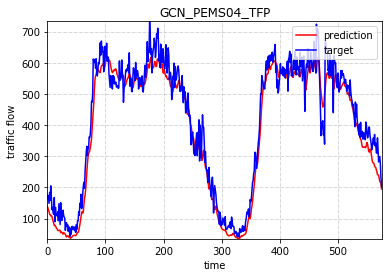

In [18]:
# main()
visualize_result(h5_file="asset/GCN_result04.h5",
                     nodes_id=120, #取第120号节点
                     time_se=[0, 24 * 12 * 2],#时间从0-576
                     visualize_file="asset/gcn_pems04_node_120")

## FedProx

### 系统异质性模拟

根据异质性所对应的设备百分比，为选定的客户机生成周期。

将x个周期数（在[1，E]之间统一随机选择）分别分配给0%、50%或90%的选定设备。0%的设备执行少于E个纪元的工作的设置对应于没有系统异质性的环境，而90%的设备发送其部分解决方案对应于高度异质的系统。

In [29]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' 
  该方法为选定的客户生成周期列表。
  复制系统的异质性
  Params:
    百分比：客户少于E时代的百分比。
    size: 列表的总大小
    max_epochs: 本地纪元的最大值。 
  返回。
    每个客户端更新的大小时间列表

  '''

  # 如果百分比为0，则每个客户端运行E个周期。
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # 得到的客户数量要少于E个周期
    heterogenous_size = int((percentage/100) * size)
    # 产生1到E之间的异质大小的随机统一周期。
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)
    # 其余的客户将有E个周期
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size
    epoch_list = np.append(epoch_list, rem_list, axis=0)
    # 洗牌并返回
    np.random.shuffle(epoch_list)
    return epoch_list

### 本地培训（客户端更新）

在客户端对模型进行本地培训


In [30]:
class CustomDataset(Dataset):
    def __init__(self, dataset,  idxs, num_nodes=307, divide_days=[45, 14], time_interval=5, history_length=6, train_mode='train'):
        """
        :param data_path: list, ["graph file name" , "flow data file name"], 保存数据文件名的路径。
        :param num_nodes: int, 节点的数量。
        :param divide_days: list, [ days of train data, days of test data], 分割原始数据的列表。
        :param time_interval: int, 两个交通数据记录之间的时间间隔（分钟）。
        :param history_length: int, 要使用的历史数据的长度。
        :param train_mode: list, ["train", "test"].
        """
        self.dataset = dataset
        self.idxs = list(idxs)
        self.num_nodes = num_nodes
        self.train_mode = train_mode
        self.train_days = divide_days[0]  # 45   59-14 = 45, train_data
        self.test_days = divide_days[1]  # 14  7*2 = 14 ,test_data
        self.history_length = history_length  # 6 30/5 = 6, 历史长度为6
        self.time_interval = time_interval  # 5 min
        self.one_day_length = int(24 * 60 / self.time_interval) # 一整天的数据量
        # self.graph = get_adjacent_matrix(distance_file=data_path[0], num_nodes=num_nodes)
        # self.flow_norm, self.flow_data = pre_process_data(data=get_flow_data(data_path[1]), norm_dim=1)# self.flow_norm为归一化的基
        # self.flow_data = self.dataset.flow_data
        # self.flow_norm = self.dataset.flow_norm
        # self.graph = self.dataset.graph

    def __len__(self):
        # if self.train_mode == "train":
        #     return self.train_days * self.one_day_length - self.history_length   #　每个样本都能测试，测试样本数　＝　测试总长度
        # elif self.train_mode == "test":
        #     return self.test_days * self.one_day_length  #　每个样本都能测试，测试样本数　＝　测试总长度
        # else:
        #     raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        return len(self.idxs)

    def __getitem__(self, index):
        """
        :param index: int, range between [0, length - 1].
        :return:
            graph: torch.tensor, [N, N].
            data_x: torch.tensor, [N, H, D].
            data_y: torch.tensor, [N, 1, D].
        """
        # if self.train_mode == "train":
        #     index = index  #　训练集的数据是从时间０开始的，这个是每一个流量数据，要和样本（ｘ,y）区别
        # elif self.train_mode == "test":
        #     index += self.train_days * self.one_day_length #　有一个偏移量
        # else:
        #     raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        a = self.idxs[index]
        self.flow_data = self.dataset[self.idxs[index]]
        # ['flow_data']
        data_x = self.flow_data['flow_x']
        data_y = self.flow_data['flow_y']
        graph = self.dataset[self.idxs[index]]['graph']
        # data_x, data_y = LoadData.slice_data(self.flow_data, self.history_length, index, self.train_mode)
        # data_x = LoadData.to_tensor(data_x)  # [N, H, D] # 转换成张量
        # data_y = LoadData.to_tensor(data_y).unsqueeze(1)  # [N, 1, D] 　# 转换成张量，在时间维度上扩维
        # return {"graph": LoadData.to_tensor(self.graph), "flow_x": data_x, "flow_y": data_y}  #组成词典返回
        return {"graph": graph, "flow_x": data_x, "flow_y": data_y}  #组成词典返回


    @staticmethod
    def pre_process_data(data, norm_dim):  # 预处理,归一化
        """
        :param data: np.array,原始的交通流量数据
        :param norm_dim: int, 归一化的维度，就是说在哪个维度上归一化,这里是在dim=1时间维度上
        :return:
            norm_base: list, [max_data, min_data], 这个是归一化的基.
            norm_data: np.array, normalized traffic data.
        """
        norm_base = LoadData.normalize_base(data, norm_dim)  #  计算 normalize basefind the normalize base
        norm_data = LoadData.normalize_data(norm_base[0], norm_base[1], data)  # # 归一化后的流量数据
        return norm_base, norm_data  #返回基是为了恢复数据做准备的


class ClientUpdate(object):
    def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm, data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"],
                 num_nodes=307, divide_days=[45, 14], time_interval=5, history_length=6, train_mode='train'):
        # self.train_loader = DataLoader(CustomDataset(data_path, num_nodes, divide_days, time_interval, history_length, train_mode),
        #                                batch_size=batchSize, shuffle=True)
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
        # self.train_loader = DataLoader(dataset,
        #                                batch_size=batchSize, shuffle=True)
        self.algorithm = algorithm
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.my_net = GCN(in_c=6, hid_c=6, out_c=1)

    def train(self, model):
        # print("Client training for {} epochs.".format(self.epochs))
        criterion = nn.CrossEntropyLoss()
        proximal_criterion = nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        # 利用全局模型的权重进行近端项计算。
        global_model = copy.deepcopy(model)
        # 计算本地训练时间
        start_time = time.time()
        e_loss = []
        for epoch in range(1, self.epochs+1):
            train_loss = 0.0
            model.train()
            for data in self.train_loader:
                # if torch.cuda.is_available():
                #     data = data.cuda()
                # 清除梯度
                optimizer.zero_grad()
                # 做反向传播
                predict_value = self.my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover
                # calculate the loss + the proximal term
                #         _, pred = torch.max(output, 1)
                pre = predict_value
                tru = data["flow_y"]
                if self.algorithm == 'fedprox':
                    proximal_term = 0.0
                    #迭代当前和全局模型参数
                    for w, w_t in zip(model.parameters(), global_model.parameters()) :
                        # 更新近端项常数
                        #proximal_term += torch.sum(torch.abs((w-w_t)**2))
                        proximal_term += (w-w_t).norm(2)
                    loss = proximal_criterion(pre,  tru) + (mu/2)*proximal_term
                else:
                    loss = proximal_criterion(pre,  tru) # 计算损失，切记这个loss不是标量 [B, N, 1, D],由于标签flow_y在cpu中，所以最后的预测值要放回到cpu中
                # 做反向传播
                loss.backward()
                # 执行单一的优化步骤
                optimizer.step()
                # 更新损失函数
                train_loss += loss.item()*data["flow_y"].shape[0]
                # 平均损失
            train_loss = train_loss/len(self.train_loader.dataset)
            e_loss.append(train_loss)
            # print('epoch: ', epoch, 'train_loss: ',train_loss)

        total_loss = sum(e_loss)/len(e_loss)

        return model.state_dict(), total_loss, (time.time() - start_time)


### 服务器端的培训和训练



In [43]:
def testing(model, test_data, bs, criterion):
   
    criterion = nn.MSELoss()
    test_loss = 0.0
    test_loader = DataLoader(test_data, batch_size=bs, shuffle=False, num_workers=0)
    l = len(test_loader)
    model.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, T, D],T=1 ＃ 目标数据的维度，用０填充
        Predict = np.zeros_like(Target)  #[N, T, D],T=1 # 预测数据的维度
        total_loss = 0.0
        for data in test_loader: # 一次把一个batch的测试数据取出来
            # if torch.cuda.is_available():
            #     data = data.cuda()
            predict_value = model(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]
            loss = criterion(predict_value, data["flow_y"])
            total_loss += loss.item() # 所有的batch的loss累加

            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)
            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])
        # 平均测试损失
        test_loss = total_loss/len(test_data)
        # print("Test Loss: {:.6f}\n".format(test_loss))

        Predict = np.delete(Predict, 0, axis=1)
        Target = np.delete(Target, 0, axis=1)
        
#         result_file = "asset/FedavgGCN_result04.h5"
        result_file = "asset/FedproxGCN_result04.h5"
        file_obj = h5py.File(result_file, "w")
    
        file_obj["predict"] = Predict
        file_obj["target"] = Target

        
    return test_loss,MAE,MAPE,RMSE

In [38]:
def training(model, rounds, batch_size, lr, train_data, data_dict, test_data, C, K, E, mu, percentage, plt_title, plt_color, algorithm):
    """
    函数实现了FedAvg论文中的Federated Averaging算法。
    具体来说，这个函数用于服务器端的训练和权重更新参数。
      - model。          要训练的PyTorch模型
      - rounds。         客户端更新的通信轮次
      - batch_size:      客户更新培训的批次大小
      - lr:              用于客户更新培训的学习率
      - train_data:              用于训练的数据集
      - data_dict：用于训练的数据分区类型（IID或非IID）。
      - test_data:  用于测试模型的数据
      - C：每轮随机选取进行计算的客户的分数
      - K：客户总数
      - E：每个客户端每轮对其本地数据集的训练次数。
      - mu：近端项常数
      - percentage：所选客户中E次以下的百分比
    返回。
      - model: 在服务器上训练的模型
    """
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"]
    # 加载数据
    train_data = LoadData(data_path, num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    test_data = LoadData(data_path, num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

    # 全局模型权重
    global_weights = model.state_dict()
    train_loss = []
    test_acc = []
    # 储存最后的损失，用于收敛
    last_loss = 0.0
    total_time = 0

    print(f"System heterogeneity set to {percentage}% stragglers.\n")
    print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

    for curr_round in range(1, rounds+1):
        w, local_loss, lst_local_train_time = [], [], []
        m = max(int(C*K), 1)
        heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
        heterogenous_epoch_list = np.array(heterogenous_epoch_list)
        S_t = np.random.choice(range(K), m, replace=False)
        S_t = np.array(S_t)

        # 对于联合平均，放弃所有的散兵游勇的客户。
        if algorithm == 'fedavg':
            stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
            heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
            S_t = np.delete(S_t, stragglers_indices)

        for k, epoch in zip(S_t, heterogenous_epoch_list):
            local_update = ClientUpdate(dataset=train_data, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=data_dict[k], mu=mu, algorithm=algorithm)
            weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))
            print('epochs: ', epoch, 'loss: ', loss)

            w.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))
            lst_local_train_time.append(local_train_time)

        # 计算更新全局权重的时间
        global_start_time = time.time()

        # 更新全局权重
        weights_avg = copy.deepcopy(w[0])
        for k in weights_avg.keys():
            for i in range(1, len(w)):
                weights_avg[k] += w[i][k]
            weights_avg[k] = torch.div(weights_avg[k], len(w))

        global_weights = weights_avg
        global_end_time = time.time()

        # 计算总时间
        total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)
        # 将更新后的权重移到我们的模型状态下。
        model.load_state_dict(global_weights)
        loss_avg = sum(local_loss) / len(local_loss)

        # 测试性能
        criterion = nn.MSELoss()
        test_loss, MAE,MAPE,RMSE = testing(model, test_data, 128, criterion)
        print(f"Round: {curr_round}... \tAverage Train Loss: {round(loss_avg, 3)}... \tTest Loss: {test_loss}")
        print("Performance:  MAE {:2.2f}    MAPE {:2.2f}%    RMSE {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))
        train_loss.append(loss_avg)  
        
         # 如果我们实现了收敛，即连续两轮之间的损失<0.0001，就会中断。
        if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 0.0001:
            rounds = curr_round
            break
        # 更新最后的损失
        last_loss = loss_avg

    #  画出训练损失
    fig, ax = plt.subplots()
    x_axis = np.arange(1, rounds+1)
    y_axis = np.array(train_loss)
    ax.plot(x_axis, y_axis)

    ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
           title=plt_title)
    ax.grid()
    fig.savefig(plt_title+'.jpg', format='jpg')
#     visualize_result(h5_file="asset/FedavgGCN_result04.h5",
#                      nodes_id=120, #取第120号节点
#                      time_se=[0, 24 * 12 * 2],#时间从0-576
#                      visualize_file="asset/fedavggcn_pems04_node_120")

    print("Training Done!")
    # print("Total time taken to Train: {}".format(get_time_format(total_time)))

    return model

## Special Case of FedProx with mu = 0 where it is Federated Averaging FedProx的特殊情况，mu=0，其中是联邦平均法。

# 与联邦平均IID分区比较。

> 在一个高度异质的系统（90%）中，与Federated Averaging相比，FedProx的损失降低了很多。

通过上面的第一个测试，我们知道，在**mu=0**的特殊情况下，FedProx与FedAvg的结果相匹配。

我们将采用同样的思路，但这次要增加我们的杂散人员。我们将在**mu>0**的情况下进行同样的试验，比较FedProx的结果。

### Training Federated Averaging with 90% stragglers (IID Partition)

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

epochs:  50 loss:  0.03396660658451476
Round: 1... 	Average Train Loss: 0.034... 	Test Loss: 0.0016356874968753094
Performance:  MAE 192.89    MAPE 0.81%    RMSE 237.06
epochs:  50 loss:  0.23759806894516758
Round: 2... 	Average Train Loss: 0.238... 	Test Loss: 0.0016356874968753094
Performance:  MAE 192.89    MAPE 0.81%    RMSE 237.06
epochs:  50 loss:  0.21930535859724343
Round: 3... 	Average Train Loss: 0.219... 	Test Loss: 0.0016356874968753094
Performance:  MAE 192.89    MAPE 0.81%    RMSE 237.06
epochs:  50 loss:  0.2218476526046446
Round: 4... 	Average Train Loss: 0.222... 	Test Loss: 0.0016356874968753094
Performance:  MAE 192.89    MAPE 0.81%    RMSE 237.06
epochs:  50 loss:  0.11341538125461384
Round: 5... 	Average Train Loss: 0.113... 	Test Loss: 0.0016356874968753094
Performance:  MAE 192.89    MAPE 0.81%    RMSE 237.06
epochs:  50 loss:  0.06951486434123312
Round: 6... 	Average Train Loss: 0

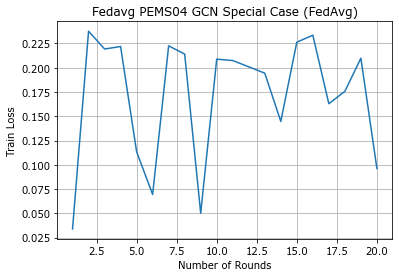

In [42]:
# 客户端更新的通信轮次
rounds = 20
# 每轮随机选取进行计算的客户的分数
C = 0.1
# 客户总数
K = 100
# 每个客户端每轮对其本地数据集的训练次数。
E = 50
# 客户更新培训的批次大小
batch_size = 10
# learning Rate
lr=0.01
#近端项常数
mu = 0.0
# 少于E周期数的客户百分比
percentage = 90
# # 目标测试精度
# target_test_accuracy=99.0
# 用于训练的数据分区类型（IID或非IID）。
iid_dict = iid_partition(train_data, 100)
# 加载模型
gcn = GCN(6,6,1)

# if torch.cuda.is_available():
#   gcn.cuda()

pems04_gcn_iid_trained_fedavg = training(gcn, rounds, batch_size, lr, train_data, iid_dict, test_data, C, K, E, mu, percentage, "Fedavg PEMS04 GCN (90% Stragglers)", "orange", algorithm='fedavg')
 # 画出预测与目标对比图



### Training FedProx with 90% Stragglers (IID Parition)

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

epochs:  17 loss:  0.12430271146860615
epochs:  48 loss:  0.23700204435062114
epochs:  6 loss:  0.11458811385301965
epochs:  5 loss:  0.07384438038796418
epochs:  20 loss:  0.2569540302363015
epochs:  28 loss:  0.20667650512649635
epochs:  50 loss:  0.17182252010980317
epochs:  39 loss:  0.20043995503585732
epochs:  38 loss:  0.12900925051270457
epochs:  5 loss:  0.1847871568082839
Round: 1... 	Average Train Loss: 0.17... 	Test Loss: 0.0010266346045740185
Performance:  MAE 151.24    MAPE 0.66%    RMSE 188.06
epochs:  17 loss:  0.06543259298521473
epochs:  43 loss:  0.2419007721934445
epochs:  5 loss:  0.22527371691178905
epochs:  34 loss:  0.19615566327393297
epochs:  50 loss:  0.1186865253937106
epochs:  35 loss:  0.20829212589649398
epochs:  22 loss:  0.07070373639154597
epochs:  45 loss:  0.07756978720041516
epochs:  41 loss:  0.22439352492401246
epochs:  8 loss:  0.06290779200331995
Round: 2... 	Aver

epochs:  26 loss:  0.12443962988549748
epochs:  15 loss:  0.20292703517031604
epochs:  41 loss:  0.1601416478269852
epochs:  14 loss:  0.20628225638356848
epochs:  11 loss:  0.1385498232916365
epochs:  18 loss:  0.20471008506689373
epochs:  50 loss:  0.06994395875769067
epochs:  14 loss:  0.2252737187129648
epochs:  43 loss:  0.029024205469595696
epochs:  5 loss:  0.2127093341461448
Round: 17... 	Average Train Loss: 0.157... 	Test Loss: 0.00102663463044409
Performance:  MAE 151.24    MAPE 0.66%    RMSE 188.06
epochs:  50 loss:  0.1350758801527726
epochs:  28 loss:  0.21819976016318016
epochs:  13 loss:  0.1950162705489405
epochs:  19 loss:  0.2160683729329045
epochs:  5 loss:  0.13927758704553278
epochs:  40 loss:  0.05507277929216856
epochs:  14 loss:  0.23673998223718745
epochs:  21 loss:  0.22477018906593588
epochs:  5 loss:  0.0919423582710961
epochs:  38 loss:  0.06624541703576656
Round: 18... 	Average Train Loss: 0.158... 	Test Loss: 0.00102663463044409
Performance:  MAE 151.24  

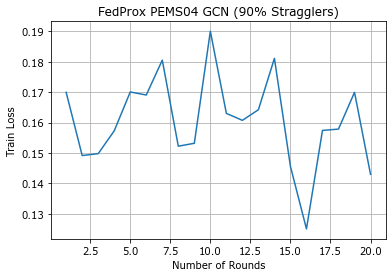

In [45]:
# 客户端更新的通信轮次
rounds = 20
#每轮随机选取进行计算的客户的分数
C = 0.1
# 客户总数
K = 100
#每个客户端每轮对其本地数据集的训练次数。
E = 50
# 客户更新培训的批次大小
batch_size = 10
# learning Rate
lr=0.01
# 近端项常数
mu = 0.01
# 少于E周期的客户百分比
percentage = 90
# target test accuracy
# target_test_accuracy = 99.0

# 用于训练的数据分区类型（IID或非IID）。
iid_dict = iid_partition(train_data, 100)
# load model
gcn = GCN(6,6,1)

# if torch.cuda.is_available():
#    cheb.cuda()

pems_gcn_iid_trained_fedprox = training(gcn, rounds, batch_size, lr, train_data, iid_dict, test_data, C, K, E, mu, percentage, "FedProx PEMS04 GCN (90% Stragglers)", "green", algorithm='fedprox')